# Recommending AirBnB prices for listings

One of my course projects for my eCornell graduate certificate in Applied Machine Learning and AI was to build and compare models designed to recommend what an AirBnB host should charge for their place in NYC based on historical data. I built a variety of models, had to rebalance the dataset and remove some features, but ended up with a model having an R2 of 0.97.

A preprocessed dataset covering about 28,000 AirBnB listings was provided from Kaggle and covered 50 features about each listing, such as number of bedrooms/bathrooms/beds, review history, availability history, neighborhood, and more. Many of the features had already been normalized and standardized.

This specific eCornell course was focused on comparing and optimizing ensemble models, which are models that combine disparate linear models such as Linear Regression, Decision Trees, Random Forests, and Gradient Boosted Decision Trees. Ensemble models are great at combining the strengths of different algorithms to increase performance, but come at the cost of decreased explainability and increased training time.

First, I trained each of the individual models and optimized their hyperparameters using a grid search. The target column, price, had been normalized by someone on Kaggle. I was interested in the absolute fit of regressors, so I chose the primary performance metric as Root Mean Squared Error (RSME). R2 was used as a secondary metric since it measures relative fit.

Gradient Boosted Decision Tree outperformed the other models with the lowest RSME (0.407) and highest R2 (0.97), but had the longest training time (47 seconds).

Second, I fit a series of stacking (ensemble) models that combined all four of the independent models and minimized the RSME using a grid search on each individual model’s hyperparameters. I tried a few rounds of different hyperparameter combinations to ensure I was locating a minimum. Fitting 1,000 models on my Macbook Air took a while, so I migrated my Jupyter notebook to a paid instance on LambdaLabs. LambaLabs’s gpu_1x_a10 instance has 30 CPU cores, 24 GB RAM, and an NVIDIA A10 for $0.75 per hour. SciKit Learn can't leverage GPUs, but it was able to max out all 30 CPU cores on the instance. The ensemble model took much longer to train (3x-10x) and didn’t perform much better than the Gradient Boosted Decision Tree, so I stopped using ensemble models.

Finally, the performance of the models was visualized and compared.

As the ground truth price increased, so did the error. I plotted the error as a function of price and noticed the mean error stayed near zero for the first 30% of the price range, and then grew quadratically. I brute forced a lot of hyper parameter combinations to attempt to get the RSME below 0.7, but just couldn’t get it any lower, even after thousands of fits.

After hitting a wall, I went back to exploratory data analysis to investigate feature correlations and target distribution. Since someone else on Kaggle had done all the data preparation, I didn’t know what all they had done or why. The price column had been standardized to have a mean of zero and standard deviation of one. The range of the price was [-0.89, 6.0], but 80% of the price samples are in the range of [-0.89, 0.36] which is only the bottom 18% of the price range.

That’s a very imbalanced dataset, with strong representation on the low prices, and hardly any representation on the high end. The dataset clearly needed to be rebalanced. I upsampled the underrepresented prices above 2.0 so that half the dataset was below 2.0 and half of it was above 2.0. I also removed some features that had either low correlation (< 0.1) with the target or had data leakage (high correlation with other features).

The model performance significantly increased overall. The RSME was almost cut in half, and the R2 lept from 0.6 to 0.97.

What I would do differently next time:
Spend more time in exploratory data analysis before modeling. Visualize incremental changes along the way as a sanity check. I could have saved myself hours of grief if I had studied the target distribution and feature correlation more.
Keep it as simple as possible for as long as possible - make yourself justify using advanced methods if basic methods are not meeting the performance requirements.
Implement my own functions for training and evaluating earlier, rather than saving it for the end. Copying and pasting all over the place was a pain and led to small bugs and inconsistent results.
Use XGBoost instead of SciKit Learn - leverage GPUs and higher speeds for mass training.

Future work ideas:

Hyperparameter tuning & Model Selection:
* Randomize the feature subset selection
* Investigate additional cross validation values beyond 3 and 5
* Try recreating the ensemble model, but leave out the poor performers like the Linear Regression

Feature engineering:
* Drop more features that have low correlation with the target (price).
* Drop more features that have data leakage (high correlation with other features).


In [1]:
# Virtual Environment creation and installing dependencies
# !virtualenv .venv
# !source .venv/bin/activate
#%pip install --upgrade pip
#%pip install -r requirements.txt

# LambdaLabs uses an older version of JupyterLab, v4.0.9. Current is 4.2.1

# have to run once in Lambda Labs instances:
# Must upgrade all of these packages on Lambda Labs, otherwise it will cause errors
# %pip install --upgrade pip bottleneck pandas scikit-learn scipy numpy matplotlib pyarrow seaborn numexpr jupyterlab jupyter ipykernel jupyter-server ydata-profiling anaconda-cloud-auth
# print('Finished installing/upgrading PIP packages')

In [2]:
# get a list of pip packages as they are right now, have to include the --format as a workaround for known bug in pip
# %pip  list --format=freeze

In [3]:
import os
import socket
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import pyarrow as pa
import pyarrow.parquet as pq

sns.set_theme(style="darkgrid")

# Configuration - defining constants

In [4]:
orig_input_filename = os.path.join(os.getcwd(), "data", "airbnb_readytofit.csv.gz")                                        # original file

# input_filename = os.path.join(os.getcwd(), "data", "airbnb_readytofit.csv_data_leakage_reduced_downsampled.csv")      # some columns that correlated with each other removed, lower prices downsampled
# input_filename = os.path.join(os.getcwd(), "data", "airbnb_readytofit.csv_downsampled.csv")                           # lower prices downsampled, no other changes
# input_filename = os.path.join(os.getcwd(), "data", "airbnb_readytofit.csv_reduced_features_downsampled.csv")          # only kept features that had decent correlation with target, lower prices downsampled
input_filename = os.path.join(os.getcwd(), "data", "airbnb_readytofit.csv_upsampled.csv")                               # higher prices upsampled, no other changes

RANDOM_STATE    = 1234      # random seed for reproducable results
TEST_SIZE       = 0.30      # percent of dataset to reserve for testing
TARGET_COL_NAME = 'price'   # in this project, the target column being studied is the price.

# Hyperparameter configurations
NUM_CV_FOLDS               = 5
# MAX_DEPTH_START            = 2
# MAX_DEPTH_HIGHEST_EXPONENT = 4
# N_ESTIMATORS               = [100, 200]
# MIN_SAMPLES_PER_LEAF_PERCENTAGES = [0.01, 0.10, 0.20]

# Performance metrics to use when evaluating models with Grid Search
scoring = {"NRSME": "neg_root_mean_squared_error", "R2": make_scorer(r2_score)}

## Configuration - Speed Enhancements
mutliprocessing, C libraries, GPU support, etc.

In [5]:
N_JOBS = -1

# Optional performance enhancements, don't always work in Lambda Labs instances
%load_ext Cython
import numba
numba.set_num_threads(4)

### Load the Data and split it into Training and Test Sets

In [6]:
df = pd.read_csv(input_filename, header=0,
                  dtype_backend='pyarrow',
                  engine='pyarrow')

y = df[TARGET_COL_NAME]
X = df.drop(columns = TARGET_COL_NAME, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

## Function definitions

In [19]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')


def plot_model_fit(ground_truth, predicted):
    x_values  = np.arange(len(ground_truth))
    df_tmp = pd.DataFrame({'ground_truth': ground_truth,
                            'predicted': predicted})
    df_tmp.sort_values('predicted', inplace=True)

    fig = plt.figure(figsize=(15, 6.5))
    ax = fig.add_subplot(111)
    sns.lineplot(x=x_values, y=df_tmp['ground_truth'], linewidth=0.1,
                    legend="full", label='Ground Truth (actual price)')
    sns.lineplot(x=x_values, y=df_tmp['predicted'], linewidth=0.75,
                    legend="full", label='Model Prediction')

    plt.title(f'Predicting AirBnB values')
    plt.ylabel("AirBnB listing's price on a standardized scale of -1 to 6")
    plt.ylim([-1, 6.1])
    plt.xticks(visible=False)
    plt.show()


def plot_error(series1, series2):
    x_values  = np.arange(len(series1))
    series_diff = series1 - series2
    
    fig = plt.figure(figsize=(15, 6.5))
    ax = fig.add_subplot(111)
    sns.lineplot(x=x_values, y=series_diff, linewidth=0.1,
                    legend="full")
    plt.title(f'Difference (error) in predicted price and actual price')
    plt.ylabel("Error")
    plt.xticks(visible=False)
    plt.show()


def compare_model_to_csv(model_name, csv_filepath):
    df_compare = pd.read_csv(csv_filepath, header=0,
                    dtype_backend='pyarrow',
                    engine='pyarrow')
    
    y_compare = df_compare[TARGET_COL_NAME]
    X_compare = df_compare.drop(columns=TARGET_COL_NAME, axis=1)
    # do not split the data into test and train groups
    
    y_compare_pred = model_name.predict(X_compare)
    rmse_compare = np.sqrt(mean_squared_error(y_compare, y_compare_pred))
    r2_compare = r2_score(y_compare, y_compare_pred)

    name_str = model_name.__name__

    print(f'* [{name_str}] Root Mean Squared Error: {round(rmse_compare, 4)}')
    print(f'* [{name_str}] R²: {round(r2_compare, 4)}')

    plot_model_fit(y_compare, y_compare_pred)
    plot_error(y_compare_pred, y_compare)


def optimize_model(ModelConstructor, model_params, verbose=1):
    model_name = ModelConstructor.__name__
    generic_grid = GridSearchCV(ModelConstructor(), model_params, cv=NUM_CV_FOLDS, verbose=verbose, scoring=scoring, refit='NRSME', n_jobs=N_JOBS)

    grid_time_start = time.time()
    generic_grid.fit(X_train, y_train)
    grid_time_stop = time.time()
    grid_time_total = grid_time_stop - grid_time_start

    generic_mean_fit_time = generic_grid.cv_results_['mean_fit_time'][generic_grid.best_index_]
    generic_mean_score_time = generic_grid.cv_results_['mean_score_time'][generic_grid.best_index_]

    primary_scoring_metric_name = next(iter(generic_grid.scorer_))

    best_params = generic_grid.best_params_

    print(f'* [{model_name}] Paramaters searched: {model_params}')
    print(f'* [{model_name}] Total Grid Search Time: {grid_time_total:.1f} sec')
    print(f'* [{model_name}] Best {primary_scoring_metric_name} score: {generic_grid.best_score_:.4f}')
    print(f'* [{model_name}] Mean fit time: {generic_mean_fit_time:.2f} sec')
    print(f'* [{model_name}] Mean score time: {generic_mean_score_time:.2f} sec')
    print(f'* [{model_name}] Best parameters: {best_params}')

    opt_model = ModelConstructor(**generic_grid.best_params_)
    time_start = time.time()
    opt_model.fit(X_train, y_train)
    time_stop = time.time()
    train_time = time_stop - time_start

    # make predictions on the test data.
    y_pred = opt_model.predict(X_test)

    # Compute the RMSE and R2
    local_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    local_test_r2   = r2_score(y_test, y_pred)

    return opt_model, local_test_rmse, local_test_r2, train_time, best_params

## Fit and Evaluate Individual Regression Models

### Individual Model: Linear Regression

Fitting 5 folds for each of 2 candidates, totalling 10 fits
* [LinearRegression] Paramaters searched: {'fit_intercept': [True, False], 'n_jobs': [-1]}
* [LinearRegression] Total Grid Search Time: 0.3 sec
* [LinearRegression] Best NRSME score: -1.5530
* [LinearRegression] Mean fit time: 0.03 sec
* [LinearRegression] Mean score time: 0.00 sec
* [LinearRegression] Best parameters: {'fit_intercept': False, 'n_jobs': -1}

In [20]:
LR_params = {
    'fit_intercept': [True, False],
    'n_jobs': [N_JOBS], # must be list, not scalar
    }

best_LR_model, best_LR_test_rmse, best_LR_test_r2, best_LR_train_time, best_LR_params = optimize_model(LinearRegression, LR_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
* [LinearRegression] Paramaters searched: {'fit_intercept': [True, False], 'n_jobs': [-1]}
* [LinearRegression] Total Grid Search Time: 0.3 sec
* [LinearRegression] Best NRSME score: -1.5530
* [LinearRegression] Mean fit time: 0.03 sec
* [LinearRegression] Mean score time: 0.00 sec
* [LinearRegression] Best parameters: {'fit_intercept': False, 'n_jobs': -1}


### Individual Model: Decision Tree

Fitting 5 folds for each of 30 candidates, totalling 150 fits
* [DecisionTreeRegressor] Paramaters searched: {'max_depth': [4, 8, 16, 32, 64], 'splitter': ['best', 'random'], 'max_features': [None, 'sqrt', 'log2']}
* [DecisionTreeRegressor] Total Grid Search Time: 2.8 sec
* [DecisionTreeRegressor] Best NRSME score: -0.6024
* [DecisionTreeRegressor] Mean fit time: 0.13 sec
* [DecisionTreeRegressor] Mean score time: 0.01 sec
* [DecisionTreeRegressor] Best parameters: {'max_depth': 32, 'max_features': None, 'splitter': 'random'}

In [21]:
DT_params = {
    'max_depth': [4, 8, 16, 32, 64],
     # 'min_samples_leaf': [1],
    'splitter': ['best', 'random'],
    'max_features': [None, 'sqrt', 'log2'],  # Default: None
    }

best_DT_model, best_DT_test_rmse, best_DT_test_r2, best_DT_train_time, best_DT_params = optimize_model(DecisionTreeRegressor, DT_params)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
* [DecisionTreeRegressor] Paramaters searched: {'max_depth': [4, 8, 16, 32, 64], 'splitter': ['best', 'random'], 'max_features': [None, 'sqrt', 'log2']}
* [DecisionTreeRegressor] Total Grid Search Time: 2.8 sec
* [DecisionTreeRegressor] Best NRSME score: -0.6024
* [DecisionTreeRegressor] Mean fit time: 0.13 sec
* [DecisionTreeRegressor] Mean score time: 0.01 sec
* [DecisionTreeRegressor] Best parameters: {'max_depth': 32, 'max_features': None, 'splitter': 'random'}


### Individual Model: Gradient Boosted Decision Tree


In a previous project, I ran a grid search to find the best model hyperparameters for the gradient boosted decision tree.
The best values were: `max_depth=2`, and `n_estimators = 300`.

 <!-- Training times on Macbook Pro:

  * 9.55 s ± 348 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
  * 9.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) with pyarrow backend -->

[comment]: <> (Performance)
[comment]: <> ( * Root Mean Squared Error: 0.6606)
[comment]: <> ( * R2: 0.5864)

Total runtime: 15 minutes
Fitting 5 folds for each of 20 candidates, totalling 100 fits
* [GradientBoostingRegressor] Best NRSME score: -0.4191
* [GradientBoostingRegressor] Mean fit time: 55.40 sec
* [GradientBoostingRegressor] Mean score time: 0.08 sec
* [GradientBoostingRegressor] Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'tol': 0.005}

In [10]:
GBDT_params = {
    'max_depth': [2, 4, 8, 16, 32],                        # Default: 3
    'n_estimators': [100, 300],                             # Default: 100
    'learning_rate': [0.1, 0.05],                           # Default: 0.1
    #'min_samples_split': [2],                   # Default: 2
    #'min_samples_leaf': [1],                    # Default: 1
    #'max_features': [None, 'sqrt', 'log2', '2'],  # Default: None
    #'warm_start': [False, True],                # Default: False
    'tol': [0.005]                              # Default: 1e-4
    }

best_GBDT_model, best_GBDT_test_rmse, best_GBDT_test_r2, best_GBDT_train_time, best_GBDT_params = optimize_model(GradientBoostingRegressor, GBDT_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
* [GradientBoostingRegressor] Best NRSME score: -0.4191
* [GradientBoostingRegressor] Mean fit time: 55.40 sec
* [GradientBoostingRegressor] Mean score time: 0.08 sec
* [GradientBoostingRegressor] Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'tol': 0.005}


### Individual Model: Random Forest

<!-- Training times on Macbook Pro:
 * 1min 13s ± 1.27 s per loop (mean ± std. dev. of 5 runs, 1 loop each)
 * 20.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) when n_jobs=N_JOBS with default backend
 * 14.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) when n_jobs=N_JOBS and pyarrow backend -->


[comment]: <> (Performance:)
[comment]: <> ( * Root Mean Squared Error: 0.6289)
[comment]: <> ( * R2: 0.6254)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
* [RandomForestRegressor] Paramaters searched: {'max_depth': [16], 'n_estimators': [100]}
* [RandomForestRegressor] Total Grid Search Time: 31.9 sec
* [RandomForestRegressor] Best NRSME score: -0.4425
* [RandomForestRegressor] Mean fit time: 15.41 sec
* [RandomForestRegressor] Mean score time: 0.08 sec
* [RandomForestRegressor] Best parameters: {'max_depth': 16, 'n_estimators': 100}

In [22]:
rf_params = {
    "max_depth":        [16],
    "n_estimators":     [100],
    # "min_samples_leaf": [25, 50, 100, 250, 500],
}

best_RF_model, best_RF_test_rmse, best_RF_test_r2, best_RF_train_time, best_RF_params = optimize_model(RandomForestRegressor, rf_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
* [RandomForestRegressor] Paramaters searched: {'max_depth': [16], 'n_estimators': [100]}
* [RandomForestRegressor] Total Grid Search Time: 31.9 sec
* [RandomForestRegressor] Best NRSME score: -0.4425
* [RandomForestRegressor] Mean fit time: 15.41 sec
* [RandomForestRegressor] Mean score time: 0.08 sec
* [RandomForestRegressor] Best parameters: {'max_depth': 16, 'n_estimators': 100}


## Comparing the Performance of models

Visualizing the RMSE and R2 scores

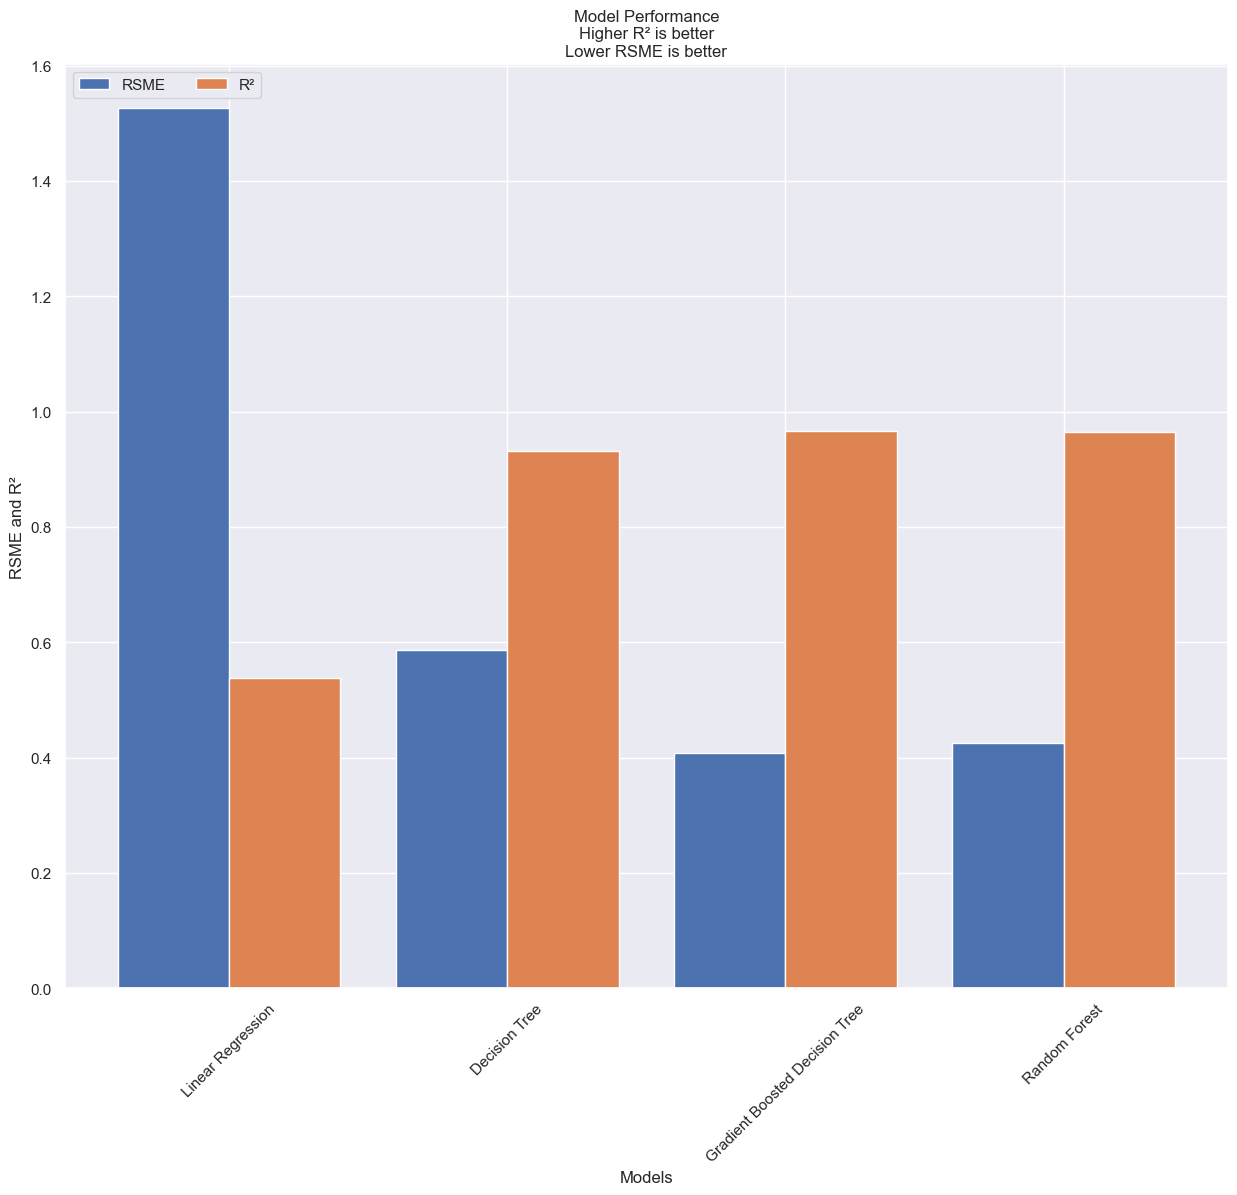

In [31]:
# create lists of the results from previous runs
alg_names       = ['Linear Regression', 'Decision Tree', 'Gradient Boosted Decision Tree', 'Random Forest']
runtimes_in_sec = [best_LR_train_time, best_DT_train_time, best_GBDT_train_time, best_RF_train_time]
RMSE_Results    = [best_LR_test_rmse, best_DT_test_rmse, best_GBDT_test_rmse, best_RF_test_rmse]
R2_Results      = [best_LR_test_r2, best_DT_test_r2, best_GBDT_test_r2, best_RF_test_r2]

rg = np.arange(len(alg_names))
width = 0.35

# Create bar plot with RMSE results
fig = plt.figure(figsize=(15,12))
plt.bar(rg - 0.2, RMSE_Results, 0.4, label = 'RSME')

# Create bar plot with R2 results
plt.bar(rg + 0.2, R2_Results,   0.4, label = 'R²')

# label each model's name
plt.xticks(rg, alg_names, rotation=45)

# Label the x (Models) and y axis (RSME and R2) of the plot
localhostname = socket.gethostname()
plt.xlabel("Models")
plt.ylabel("RSME and R²")
plt.title(f"Model Performance\nHigher R² is better\nLower RSME is better")
plt.legend(loc='upper left', ncol=2)
plt.show()

# Training time Analysis

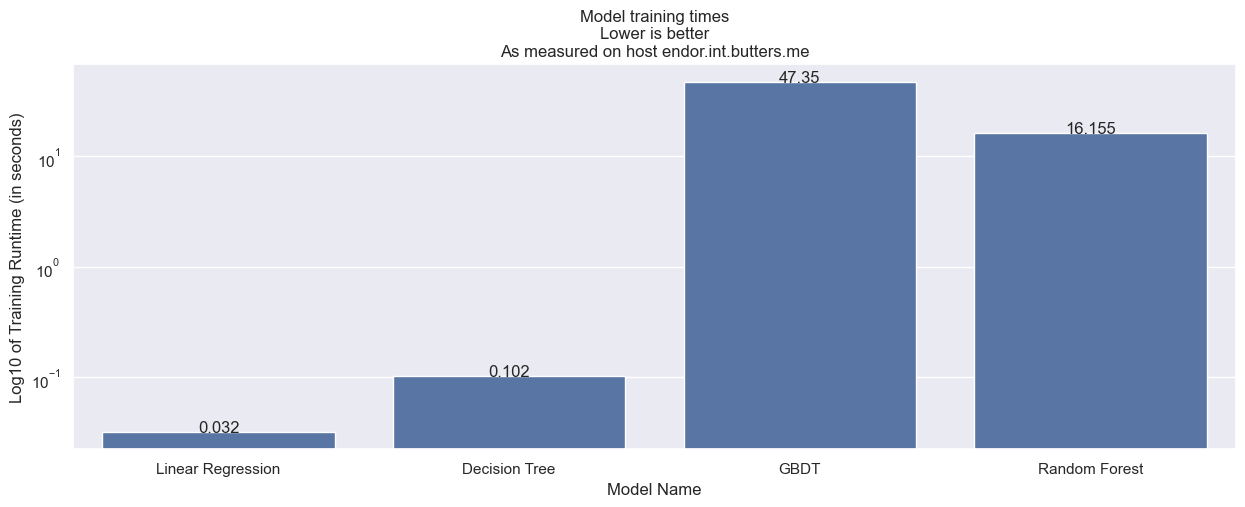

In [30]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x=alg_names, y=runtimes_in_sec)
addlabels(alg_names, np.round(runtimes_in_sec,3))
plt.title(f'Model training times\nLower is better\nAs measured on host {localhostname}')
g = ax.set_xlabel('Model Name')
g = ax.set_ylabel('Log10 of Training Runtime (in seconds)')
ax.set_yscale("log")

# Plotting the models vs the original data

In [ ]:
df_orig = pd.read_csv(orig_input_filename, header=0,
                    dtype_backend='pyarrow',
                    engine='pyarrow')
    
y_orig = df_orig[TARGET_COL_NAME]
X_orig = df_orig.drop(columns=TARGET_COL_NAME, axis=1)
df_model_comparison = pd.DataFrame(y_orig.rename('Ground Truth Price'))
df_model_comparison['Linear Regression'] = best_LR_model.predict(X_orig)
df_model_comparison['Decision Tree']     = best_DT_model.predict(X_orig)
df_model_comparison['GBDT']              = best_GBDT_model.predict(X_orig)
df_model_comparison['Random Forest']     = best_RF_model.predict(X_orig)
df_model_comparison.sort_values(by='GBDT', inplace=True)
x_values  = np.arange(len(df_model_comparison['Ground Truth Price']))

df_error = pd.DataFrame(df_model_comparison['Ground Truth Price'])
for colname in df_model_comparison.columns:
    if colname == 'Ground Truth Price':
        continue
    
    df_error[colname] = df_model_comparison[colname] - df_model_comparison['Ground Truth Price']

df_error.sort_values(by='Ground Truth Price', inplace=True)

# df_error.head()

In [126]:
sns.set_theme(style="darkgrid")

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 120

X_LIM = (-1, 6.1)
Y_LIM = X_LIM

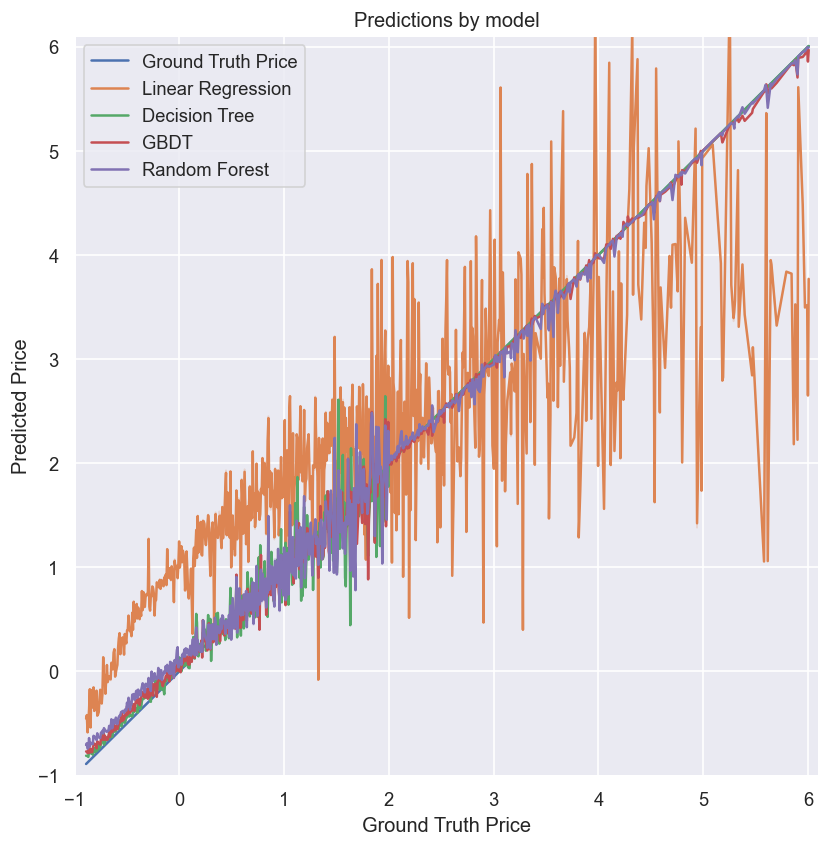

In [127]:
for colname in df_model_comparison.columns:
    ax = sns.lineplot(data=df_model_comparison, x='Ground Truth Price', y=colname, label=colname, errorbar=('ci', 3) )

ax.set(xlabel='Ground Truth Price',
       ylabel='Predicted Price',
       title='Predictions by model',
       ylim=Y_LIM,
       xlim=X_LIM)

plt.show()


In [128]:
# ax = sns.lineplot(data=df_model_comparison, x=x_values, y='Ground Truth Price')
# sns.lineplot(data=df_model_comparison, x=x_values, y='GBDT')
# sns.lineplot(data=df_model_comparison, x=x_values, y='Linear Regression')
# sns.lineplot(data=df_model_comparison, x=x_values, y='Decision Tree')
# sns.lineplot(data=df_model_comparison, x=x_values, y='Random Forest')

# ax.set(xlabel='',
#        ylabel='Predicted Price',
#        title='Predicted Prices by model')
#        #ylim=Y_LIM,
#        #xlim=X_LIM)

# plt.show()

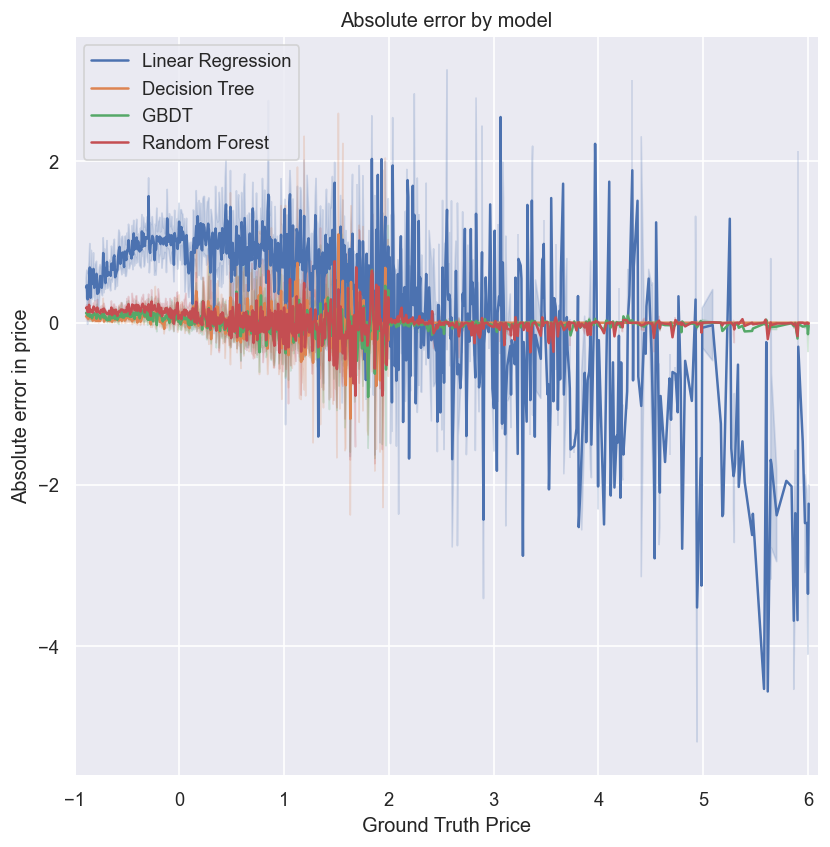

In [129]:
for colname in df_error.columns:
    if colname == 'Ground Truth Price':
        continue
    ax = sns.lineplot(data=df_error, x='Ground Truth Price', y=colname, label=colname)
    
ax.set(xlabel='Ground Truth Price',
       ylabel='Absolute error in price',
       title='Absolute error by model',
       #ylim=Y_LIM,
       xlim=X_LIM)

plt.show()